In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, PiecewiseConstant
from osd.utilities import progress

In [4]:
def proj_l2_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(y) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(y)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d1(data, theta=1, c=1):
    """Sum of absolute value of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=1))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d2(data, theta=1, c=1):
    """Sum of absolute value of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=2))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d2(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=2)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d1(data, theta=1, c=1):
    """Sum of squares of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=1)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def make_data(length, points=None, shifts=None):
    if points is None:
        points = [0, int(length * 0.2), int(length * 0.55), int(length * 0.85), length]
    if shifts is None:
        shifts = [0, .5, -0.75, .2]
    cp = np.zeros(length)
    for ix, shft in enumerate(shifts):
        a = points[ix]
        b = points[ix + 1]
        cp[a:b] = shft
    return cp

In [5]:
def make_estimate(y, X, use_ix):
    X_tilde = np.copy(X)
    X_tilde[0, use_ix] = y - np.sum(X[1:, use_ix], axis=0)
    X_tilde[0, ~use_ix] = 0
    return X_tilde

def calc_obj(y, X, components, use_ix):
    K = len(components)
    X_tilde = make_estimate(y, X, use_ix)
    obj_val = 0
    for k in range(K):
        try: 
            cost = components[k].cost(X_tilde[k]).value.item()
        except AttributeError:
            cost = components[k].cost(X_tilde[k])
        theta = components[k].theta
        obj_val += theta * cost
    return obj_val

def run_admm(data, components, num_iter=50, rho=0.5, use_ix=None, verbose=True, randomize_start=False):
    y = data
    T = len(data)
    K = len(components)
    if use_ix is None:
        use_ix = np.ones_like(data, dtype=bool)
    u = np.zeros_like(y)
    X = np.zeros((K, T))
    if not randomize_start:
        X[0, use_ix] = y[use_ix]
    else:
        X[1:, :] = np.random.randn(K-1, T)
        X[0, use_ix] = y[use_ix] - np.sum(X[1:, use_ix], axis=0)
    residuals = []
    obj_vals = []
    ti = time()
    best = {
        'X': None,
        'u': None,
        'it': None,
        'obj_val': np.inf
    }
    for it in range(num_iter):
        if verbose:
            td = time() - ti
            progress(it, num_iter, '{:.2f} sec'.format(td))
        # Apply proximal operators
        for k in range(K):
            prox = components[k].prox_op
            theta = components[k].theta
            X[k, :] = prox(X[k, :] - u, theta, rho)
        # Consensus step
        u[use_ix] += 2 * (np.average(X[:, use_ix], axis=0) - y[use_ix] / 3)
        # mean-square-error
        error = np.sum(X[:, use_ix], axis=0) - y[use_ix]
        mse = np.sum(np.power(error, 2)) / error.size
        residuals.append(mse)
        obj_val = calc_obj(y, X, components, use_ix)
        obj_vals.append(obj_val)
        if obj_val < best['obj_val']:
            X_tilde = make_estimate(y, X, use_ix)
            best = {
                'X': X_tilde,
                'u': u,
                'it': it,
                'obj_val': obj_val
            }
    if verbose:
        td = time() - ti
        progress(it + 1, num_iter, '{:.2f} sec\n'.format(td))
    outdict = {
        'X': best['X'],
        'u': best['u'],
        'it': best['it'],
        'residuals': residuals,
        'obj_vals': obj_vals,
        'best_obj': best['obj_val']
    }
    return outdict

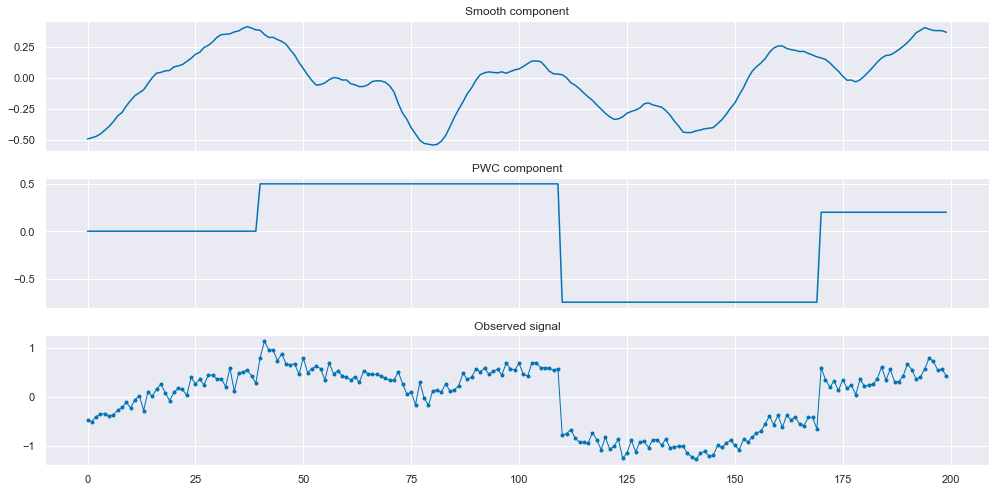

In [9]:
T = 200
X_real = np.zeros((3, T))
X_real[0] = 0.1 * np.random.randn(T)
X_real[1] = 10 * proj_l2_d1(np.random.randn(T), theta=5e2)
X_real[2] = make_data(T)
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('PWC component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

In [7]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = PiecewiseConstant(num_segments=4)
components = [c1, c2, c3]
# result = run_admm(y, components, rho=1, num_iter=100)

In [8]:
rhos = np.logspace(-1, 1, 9)
results = []
best_obj = []
for rho in rhos:
    r = run_admm(y, components, rho=rho, num_iter=100)
    results.append(r)
    best_obj.append(r['best_obj'])

[============================================================] 100.0% ...26.53 sec


KeyboardInterrupt: 

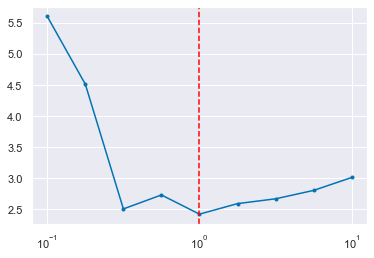

In [12]:
plt.plot(rhos, best_obj, marker='.')
plt.xscale('log')
best = np.argmin(best_obj)
plt.axvline(rhos[best], ls='--', color='red');

In [13]:
result = run_admm(y, components, rho=rhos[best], num_iter=100)

[============================================================] 100.0% ...24.81 sec


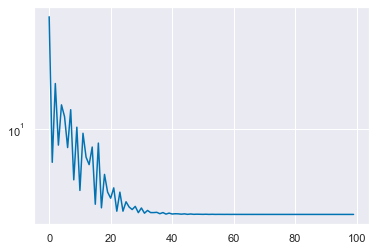

In [14]:
plt.plot(result['obj_vals'])
plt.yscale('log')
# plt.axvline(result['it'], color='red', ls='--')

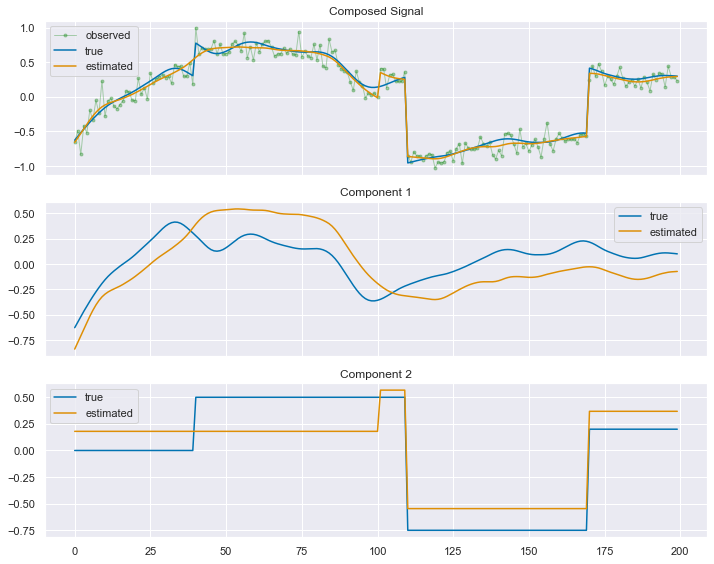

In [15]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        ax[k].plot(X_real[k], label='true')
        ax[k].plot(result['X'][k], label='estimated')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(result['X'][1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()